In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.animation import FuncAnimation
import matplotlib
import scipy.sparse as sps
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# matplotlib.rcParams['figure.figsize'] = [8, 7]
from IPython.display import clear_output

In [35]:
import os
os.chdir(r'/Volumes/GoogleDrive/My Drive/Classroom/DTU/Special Course/Report/figures/Diff')


## Initializing the Mesh

In [36]:
domain_length = 1
meshsize = 100

dx = domain_length/meshsize*np.ones((meshsize))

x = np.ones((meshsize))
x[0] = dx[0]/2
for i in range(1,meshsize):
    x[i] = x[i-1] + dx[i-1]/2+dx[i]/2

## Entering phase diagram properties

In [37]:
c0 = 2.1

ceut = 4.2
calpha = 2.1

Tf = 1537
Teut = 1153

Tliq = (Teut-Tf)/ceut*c0 + Tf
Tsol = (Teut-Tf)/calpha*c0+Tf

kpar = calpha/ceut
T_init_cast = Tliq

c = c0*np.ones((meshsize))
cinit = c.copy()

def cl(T, Tf=Tf, ceut=ceut, Teut=Teut):
    return (T-Tf)*ceut/(Teut-Tf)

def TfromCl(cl, Tf=Tf, ceut=ceut, Teut=Teut):
    return cl/ceut*(Teut-Tf)+Tf

total_mass = domain_length*c0

## Simulating temperature diffusion

In [38]:
final_t = 2000

print((Tliq-Tsol)/final_t)
#Defining temperature as a function of time. Linear, no diffusion

def temp(time,Tsol=Tsol,Tliq=Tliq,tf=final_t):
    return Tliq + (Tsol-Tliq)*time/tf

def timeFromTemp(temp, Tsol=Tsol, Tliq=Tliq, tf=final_t):
    return (temp-Tliq)/(Tsol-Tliq)*tf

0.096


## diffusion_step

In [39]:
def diffusion_step(dx,c,dt,D,b1,b2,theta=1):
    
    meshsize = len(dx)
    r = np.zeros(meshsize)

    r[0] , r[meshsize-1] = 1/b1,1/b2
    r[1:meshsize-1] = dx[1:meshsize-1]/(2*D)
    
    hcon = np.zeros(meshsize)
    hcap = np.zeros(meshsize)

    for i in range(1, meshsize):
        hcon[i] = 1/(r[i-1]+r[i])

    for i in range(1, meshsize-1):
        hcap[i] = dx[i]/dt

    Att= calcAtt(hcon,hcap,theta=theta)
    At= calcAt(hcon,hcap,theta=theta)

    return np.linalg.inv(Att)@At@c

def calcAtt(hcon, hcap,theta):
    size = len(hcap)
    Att = np.zeros((size, size))
    for i in range(0, size):
        # Left boundary condition constant concentration
        if i == 0:
            Att[i][i] = 1
            continue
        # Right boundary condition constant concentration
        if i == size-1:
            Att[i][i] = 1
            continue
        Att[i][i-1] = -theta*hcon[i]
        Att[i][i] = hcap[i] + theta*hcon[i] + hcon[i+1]*theta
        Att[i][i+1] = -theta*hcon[i+1]
    return Att
    
def calcAt(hcon, hcap,theta):
    size = len(hcap)
    At = np.zeros((size, size))
    for i in range(0, size):
        #Left boundary condition
        if i == 0:
            At[i][i] = 1
            continue
        #Right boundary condition
        if i == size-1:
            At[i][i] = 1
            continue
        At[i][i-1] = (1-theta)*hcon[i]
        At[i][i] = hcap[i]-(1-theta)*hcon[i]-(1-theta)*hcon[i+1]
        At[i][i+1] = (1-theta)*hcon[i+1]
    return At

## Simulations

In [40]:
def simulateDiffTimestep(dx, c, steps,Dsol,Dliq,fs_final=1, k=kpar,rateofchange=200,tol=1E-6):
    
    length = np.sum(dx)
    meshsize = len(dx)
    c0 = np.average(c)
    c_initial = c.copy()

    concentrations = np.zeros((steps))
    t = 0

    #Concentrations inside stepped nodes

    profiles = []

    #Total mass
    total_mass = length*c0

    #Guess initial dt
    dt = 1

    for inter in tqdm(range(round(fs_final*meshsize))):
        
        concentrations = c[inter]*np.ones((steps))

        #Declaring matrices
        new_c = np.zeros((meshsize))
        new_concentrations = np.zeros((steps))
        
        # Iterating over nodes
        for step in range(steps):
            
            T_old = temp(t)

            #Assemble arrays
            
            solid_steps_dx = dx[inter]/steps*np.ones((step+1))
            solid_steps_c = concentrations[:step+1]

            liq_steps_dx = dx[inter]/steps*np.ones((steps-(step+1)))
            liq_steps_c = concentrations[step+1:]
            
            solid_dx = np.concatenate(([dx[0]], dx[0:inter], solid_steps_dx, [dx[inter]/steps]))
            liq_dx = np.concatenate(([dx[inter]/steps], liq_steps_dx, dx[inter+1:], [dx[-1]]))
            
            #### Iterative method
            change = 1

            fs = (inter + step/steps)/meshsize
            dfs = 1/(steps*meshsize)

            cl_old = cl(T_old)
            cl_new = cl_old+ dfs/(1-fs)*cl_old*(1-k)
            T = TfromCl(cl_new)

            # dt = timeFromTemp(T)-t

            while abs(change)>tol:
                
                ######################################################
                #Solve Temperature

                T=temp(t+dt)

                ######################################################
                #Solve diffusion

                solid_c = np.concatenate(([c[0]], c[0:inter], solid_steps_c, [k*cl(T)]))
                solid_c[-2] = k*cl(T)
                liq_c = np.concatenate(([cl(T)], liq_steps_c, c[inter+1:], [c[-1]]))

                new_solid = diffusion_step(solid_dx,solid_c,dt,Dsol,1E-24,1E30)[1:-1] #Removing dead nodes

                new_liquid = diffusion_step(liq_dx,liq_c,dt,Dliq,1E24,1E-24)[1:-1] #Removing dead nodes
                
                # #Ignoring liquid diffusion
                # new_liquid = cl(T)*np.ones((len(liq_c)))[1:-1]

                ######################################################
                #Assemble final concentration
                
                new_c[0:inter] = new_solid[0:inter]
                new_c[inter+1:] = new_liquid[(steps-(step+1)):]

                new_concentrations[0:step+1] = new_solid[inter:]
                new_concentrations[step+1:] = new_liquid[0:(steps - (step+1))]
                
                new_c[inter] = np.average(new_concentrations)

                ######################################################
                # Finding change
                
                change = np.sum(dx*(new_c))-np.sum(dx*c_initial)

                dt = dt*(1-change/total_mass*rateofchange)
                
            t= t+dt
            
            ## Updating the values using new interface

            mass_change = np.sum(dx*(new_c))-np.sum(dx*c_initial)
            concentrations = new_concentrations.copy()
            c = new_c.copy()

            profiles_dx = np.concatenate((solid_dx[1:-1],liq_dx[1:-1]))
            profiles_x = np.ones((len(profiles_dx)))
            profiles_x[0] = profiles_dx[0]/2
            for i in range(1,len(profiles_dx)):
                profiles_x[i] = profiles_x[i-1] + profiles_dx[i-1]/2+profiles_dx[i]/2
                
            profiles_c = np.concatenate((new_solid,new_liquid))
            
            profiles.append(((profiles_x.copy(),profiles_c.copy()), inter+step/steps,mass_change,t,concentrations.copy()))

    return profiles


In [41]:
Dsol = 1E-10
Dliq = 1E5

steps = 5
Simulation_result = simulateDiffTimestep(dx.copy(),c.copy(),steps,Dsol,Dliq,0.8)

100%|██████████| 80/80 [00:19<00:00,  4.17it/s]


In [42]:
profiles = [Simulation_result[i][0] for i in range(len(Simulation_result))]
interface = [Simulation_result[i][1] for i in range(len(Simulation_result))]
mass_change = [Simulation_result[i][2] for i in range(len(Simulation_result))]
time = [Simulation_result[i][3] for i in range(len(Simulation_result))]
concentrations = [Simulation_result[i][4]for i in range(len(Simulation_result))]
dt = [time[i+1]-time[i] for i in range(len(time)-1)]

print(len(profiles))

400


Tf = 2467.6666336342078 s


Text(0.5, 1.0, 'Time')

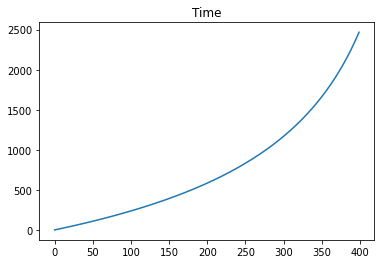

In [43]:
print("Tf = "+str(time[-1])+" s")
plt.plot(time)
plt.title('Time')

2.0080190383151053


Text(0.5, 1.0, 'dt')

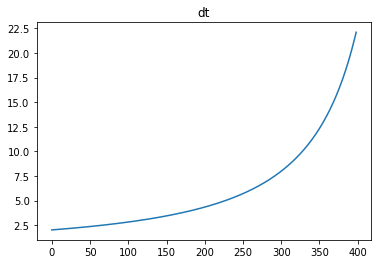

In [44]:
print(dt[0])
plt.plot(dt)
plt.title('dt')

In [45]:
fs = 1
index_f = int(fs*len(profiles))
# index = 12
@interact(index=(0,index_f-1))
def plot(index):
    plt.clf()
    plt.plot(profiles[index][0],profiles[index][1])
    plt.title('profile')
    
    # plt.ylim(np.min(profiles[0][1]),np.max(profiles[-1][1]))
    plt.show()

interactive(children=(IntSlider(value=199, description='index', max=399), Output()), _dom_classes=('widget-int…

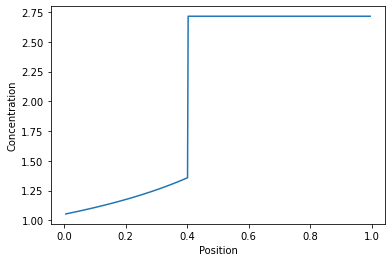

In [46]:
fs = 0.5
index = int(fs*len(profiles))
plt.plot(profiles[index][0],profiles[index][1])
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.savefig('Scheil prof.png',bbox_inches='tight',dpi = 400)

Text(0.5, 1.0, 'dm vs t')

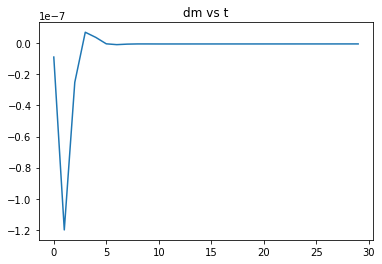

In [47]:
dm = [mass_change[i+1]-mass_change[i] for i in range(len(mass_change)-1)]
plt.plot(dm[:30])
plt.title('dm vs t')

-6.41629474884553e-07


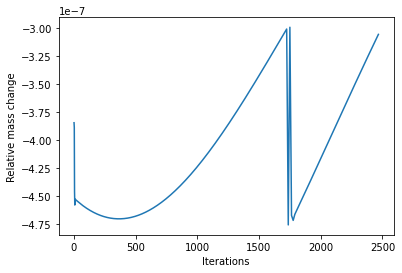

In [48]:
plt.plot(time,np.array(mass_change)/total_mass)
print(mass_change[-1])
# plt.title('Mass Change vs time')
plt.xlabel('Iterations')
plt.ylabel('Relative mass change')
plt.savefig('Scheil Loss.png',bbox_inches = 'tight',dpi=400)

Text(0.5, 1.0, 'Interface movement')

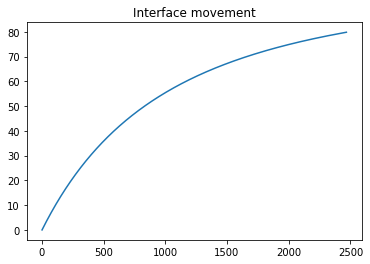

In [49]:
plt.plot(time,interface)
plt.title('Interface movement')